## How much variance does each pc explain for its cluster's genes?

I'm concerned that pcqtls are being driven by the expression of individual genes. 

Stephen suggests the following: 

"We should plot how much variance is explained by each PCqtl and see if there are some where it is imbalanced across genes or pretty similar. You could do a scatterplot of variance explained for gene 1 and gene 2 where gene 1 and 2 are the genes where the most variance is explained (for multi gene clusters beyond 2) "


qtl variance is the suqared effect size, if the data is standardized. I could also look look at the gene variance explianed by the PC itself

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm.auto import tqdm  # for notebooks
import ast
from scipy.stats import linregress
import matplotlib.patches as patches



In [19]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/pcqtl_proteincoding.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
clusters_dir = config['clusters_dir']
eqtl_output_dir = config['eqtl_output_dir']
pcqtl_output_dir = config['pcqtl_output_dir']
overlap_output_dir = config['overlap_output_dir']




# load in the tissue ids 
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])

# select just 1 tissue id to do for now 
tissue_id = 'Cells_Cultured_fibroblasts' # because only one cell type
tissue_ids = [tissue_id]

load in data

In [20]:
# load nominal p value dfs

# load in e nominal
def load_e_nominal(path):
    e_nominal_df = pd.read_parquet(path)
    e_nominal_df['cluster_id'] = e_nominal_df['phenotype_id'].str.split('_e_').str[0]
    e_nominal_df['egene_id'] = e_nominal_df['phenotype_id'].str.split('_e_').str[1]
    return e_nominal_df

e_nominal_dfs=[]
for chr_id in tqdm(range(1,23)):
    e_nominal_dfs.append(load_e_nominal(f'{prefix}/{eqtl_output_dir}/{tissue_id}/{tissue_id}.v8.cluster_genes.cis_qtl_pairs.chr{chr_id}.parquet'))

e_nominal_df = pd.concat(e_nominal_dfs)

  0%|          | 0/22 [00:00<?, ?it/s]

In [71]:
def load_pc_nominal(path):
    pc_nominal_df = pd.read_parquet(path)
    pc_nominal_df['cluster_id'] = pc_nominal_df['phenotype_id'].str.split('_pc').str[0]
    pc_nominal_df['pc_num'] = pc_nominal_df['phenotype_id'].str.split('_pc').str[1]
    return pc_nominal_df

pc_nominal_dfs=[]
for chr_id in tqdm(range(1,23)):
    pc_nominal_dfs.append(load_pc_nominal(f'{prefix}/{pcqtl_output_dir}/{tissue_id}/{tissue_id}.v8.pcs.cis_qtl_pairs.chr{chr_id}.parquet'))
pc_nominal_df = pd.concat(pc_nominal_dfs)

  0%|          | 0/22 [00:00<?, ?it/s]

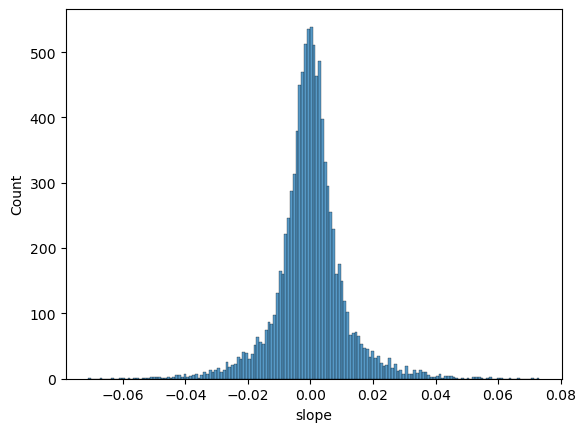

In [73]:
# Some of the variances are >100%. This would happen if the slope values are not bounded by [-1,1]
# Dan suggests this could be the case if the genotype or expression were not normalized. 
# I normalized the expression and this fixed it!


sns.histplot(pc_nominal_df.sample(10000), x='slope')
plt.show()

In [74]:
overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')

In [76]:
# label cluster-variant pairs
overlap_df['var_cluster'] = overlap_df['lead_variant_id'] + '_' + overlap_df['cluster_id']
pc_nominal_df['var_cluster'] = pc_nominal_df['variant_id'] + '_' + pc_nominal_df['cluster_id']
e_nominal_df['var_cluster'] = e_nominal_df['variant_id'] + '_' + e_nominal_df['cluster_id']

# set e_nominal to be index based on variant-cluster pairs
e_nominal_df_cid = e_nominal_df.set_index('var_cluster')


### lead variant only

start with just lead variants from susie (this is not exactly correct but will work for a first pass)

In [83]:
pc1qtl_vars = overlap_df[overlap_df['cs_full_id'].str.contains('pc1')]['var_cluster']

In [91]:
# get the eqtl effects for the pcqtl lead variants 
pc1qtl_vars_e_nominal = e_nominal_df[e_nominal_df['var_cluster'].isin(pc1qtl_vars)]
pc1qtl_vars_e_nominal.reset_index(inplace=True)
# effect size/percent varaince explined
pc1qtl_vars_e_nominal['effect_size'] = (pc1qtl_vars_e_nominal['slope']**2) * 100

/local/scratch/klawren/slrmtmp.42779555/ipykernel_21737/1359025870.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pc1qtl_vars_e_nominal['effect_size'] = (pc1qtl_vars_e_nominal['slope']**2) * 100


In [92]:
# keep only the largest and 2nd largest effect size for each cluster 
plot_df = pc1qtl_vars_e_nominal.groupby('cluster_id').apply(lambda x: x.nlargest(2, 'effect_size')).reset_index(drop=True)

# Add a rank column with grouped rank numbers
plot_df['rank'] = plot_df.groupby('cluster_id')['effect_size'].rank("dense", ascending=False)

# Pivot the DataFrame
plot_df = plot_df.pivot(index='cluster_id', columns='rank', values='effect_size')

# Rename the columns for clarity
plot_df.columns = ['largest', 'second_largest']

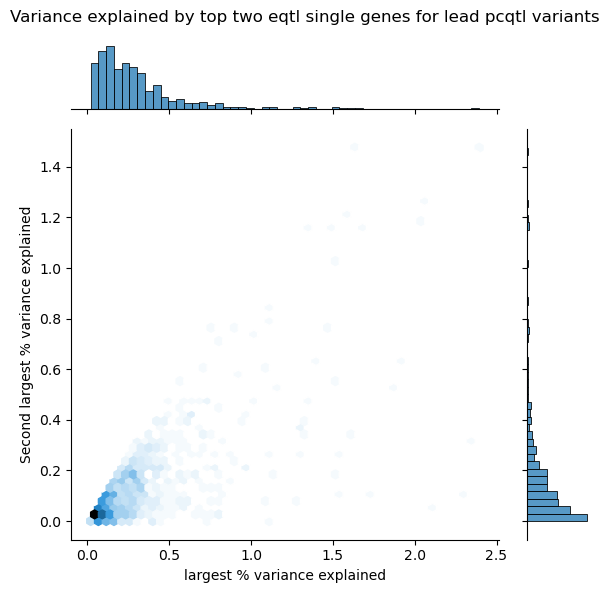

In [93]:
# Create the jointplot
jplot = sns.jointplot(data=plot_df, x='largest', y='second_largest', kind='hex', gridsize=50, marginal_kws=dict(bins=50))

# Set labels
jplot.set_axis_labels('largest % variance explained', 'Second largest % variance explained')

plt.suptitle('Variance explained by top two eqtl single genes for lead pcqtl variants')
jplot.fig.tight_layout()
# Show the plot
plt.show()


### credible set

Rather than just taking the variance of the lead snp, I can expand to take the pip*variance for the whole credible set

In [109]:
# load in the susie df, so I have the pip values for the variants as well as the slopes
pc_susie_df = pd.read_csv(f'{prefix}/{pcqtl_output_dir}/{tissue_id}/{tissue_id}.v8.pcs.susie.txt', sep='\t', index_col=0)
pc_susie_df['var_cluster'] = pc_susie_df['variant_id'] + '_' + pc_susie_df['phenotype_id'].str.split('_pc1').str[0]
pc_susie_df['cs_id'] =  pc_susie_df['phenotype_id'].str.split('_pc1').str[0] + '_' + pc_susie_df['cs_id'].astype(str)
pc_susie_df['pc_num'] = pc_susie_df['phenotype_id'].str.split('_pc').str[-1].astype(int)

In [114]:
# pull out the variants that are part of a pc1qtl credible set
pc1qtl_cs_e_nominal = e_nominal_df[e_nominal_df['var_cluster'].isin(pc_susie_df[pc_susie_df['pc_num']==1]['var_cluster'])]
pc1qtl_cs_e_nominal.reset_index(inplace=True, drop=True)

In [116]:
pc_susie_df.set_index('var_cluster')['pip']

var_cluster
chr1_966179_G_A_b38_ENSG00000187583.10_ENSG00000187961.13      0.999976
chr1_1667948_A_G_b38_ENSG00000189339.11_ENSG00000248333.8      0.327235
chr1_1668542_C_T_b38_ENSG00000189339.11_ENSG00000248333.8      0.327235
chr1_1668717_C_G_b38_ENSG00000189339.11_ENSG00000248333.8      0.327235
chr1_1694167_G_A_b38_ENSG00000189339.11_ENSG00000248333.8      0.016406
                                                                 ...   
chr9_136862025_G_A_b38_ENSG00000054148.17_ENSG00000232434.2    0.068727
chr9_136865979_G_A_b38_ENSG00000054148.17_ENSG00000232434.2    0.047727
chr9_137224523_G_A_b38_ENSG00000198569.9_ENSG00000233198.3     0.482401
chr9_137225120_C_T_b38_ENSG00000198569.9_ENSG00000233198.3     0.281377
chr9_137226375_C_G_b38_ENSG00000198569.9_ENSG00000233198.3     0.214693
Name: pip, Length: 36775, dtype: float64

In [115]:
pc1qtl_cs_e_nominal

,phenotype_id,variant_id,start_distance,end_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cluster_id,egene_id,var_cluster
0,ENSG00000187583.10_ENSG00000187961.13_e_ENSG00...,chr1_966179_G_A_b38,5592,-318,0.838509,129,156,3.469753e-24,0.053869,0.004979,ENSG00000187583.10_ENSG00000187961.13,ENSG00000187961.13,chr1_966179_G_A_b38_ENSG00000187583.10_ENSG000...
1,ENSG00000187583.10_ENSG00000187961.13_e_ENSG00...,chr1_966179_G_A_b38,5592,-318,0.838509,129,156,2.024175e-23,0.053055,0.005000,ENSG00000187583.10_ENSG00000187961.13,ENSG00000187583.10,chr1_966179_G_A_b38_ENSG00000187583.10_ENSG000...
2,ENSG00000189339.11_ENSG00000248333.8_e_ENSG000...,chr1_1667948_A_G_b38,8936,-24780,0.220497,187,213,3.547103e-10,-0.026079,0.004056,ENSG00000189339.11_ENSG00000248333.8,ENSG00000248333.8,chr1_1667948_A_G_b38_ENSG00000189339.11_ENSG00...
3,ENSG00000189339.11_ENSG00000248333.8_e_ENSG000...,chr1_1668542_C_T_b38,9530,-24186,0.220497,187,213,3.547103e-10,-0.026079,0.004056,ENSG00000189339.11_ENSG00000248333.8,ENSG00000248333.8,chr1_1668542_C_T_b38_ENSG00000189339.11_ENSG00...
4,ENSG00000189339.11_ENSG00000248333.8_e_ENSG000...,chr1_1668717_C_G_b38,9705,-24011,0.220497,187,213,3.547103e-10,-0.026079,0.004056,ENSG00000189339.11_ENSG00000248333.8,ENSG00000248333.8,chr1_1668717_C_G_b38_ENSG00000189339.11_ENSG00...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39735,ENSG00000025708.13_ENSG00000177989.13_e_ENSG00...,chr22_50532087_G_A_b38,2031,-493,0.021739,20,21,4.031859e-05,-0.053479,0.012885,ENSG00000025708.13_ENSG00000177989.13,ENSG00000177989.13,chr22_50532087_G_A_b38_ENSG00000025708.13_ENSG...
39736,ENSG00000025708.13_ENSG00000177989.13_e_ENSG00...,chr22_50532837_T_C_b38,2781,257,0.657350,278,331,3.148256e-05,0.015346,0.003646,ENSG00000025708.13_ENSG00000177989.13,ENSG00000177989.13,chr22_50532837_T_C_b38_ENSG00000025708.13_ENSG...
39737,ENSG00000025708.13_ENSG00000177989.13_e_ENSG00...,chr22_50535371_C_G_b38,5315,2791,0.021739,20,21,4.031859e-05,-0.053479,0.012885,ENSG00000025708.13_ENSG00000177989.13,ENSG00000177989.13,chr22_50535371_C_G_b38_ENSG00000025708.13_ENSG...
39738,ENSG00000025708.13_ENSG00000177989.13_e_ENSG00...,chr22_50540263_G_A_b38,10207,7683,0.022774,20,22,1.981090e-05,-0.051906,0.012023,ENSG00000025708.13_ENSG00000177989.13,ENSG00000177989.13,chr22_50540263_G_A_b38_ENSG00000025708.13_ENSG...


In [112]:


# add in the pip, then calculate the effects size as a pip weighted slope**2
pc1qtl_cs_e_nominal['pip'] = pc1qtl_cs_e_nominal['var_cluster'].map(pc_susie_df.set_index('var_cluster')['pip'])
pc1qtl_cs_e_nominal['variance'] = pc1qtl_cs_e_nominal['slope'].apply(np.square)
pc1qtl_cs_e_nominal['variance_weighted'] = pc1qtl_cs_e_nominal['variance'] * pc1qtl_cs_e_nominal['pip']

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
# group by credible set 
pc1qtl_cs_e_nominal['cs_id'] = pc1qtl_cs_e_nominal['var_cluster'].map(pc1_susie_df.set_index('var_cluster')['cs_id'])
# get the sum of pip weighted variances for the credible set
plot_df = pd.DataFrame(pc1qtl_cs_e_nominal.groupby(['cs_id', 'egene_id'])['variance_weighted'].sum())
# take just the two largest variances
plot_df = plot_df.groupby('cs_id')['variance_weighted'].nlargest(2)

In [ ]:
plot_df['rank'] = plot_df.groupby('cs_id')['variance_weighted'].rank("dense", ascending=False)


KeyError: 'Column not found: variance_weighted'

In [ ]:
# Add a rank column with grouped rank numbers
plot_df['rank'] = plot_df.groupby('cs_id')['variance_weighted'].rank("dense", ascending=False)
# Pivot the DataFrame
plot_df = plot_df.pivot(index='cs_id', columns='rank', values='effect_size')
# Rename the columns for clarity
plot_df.columns = ['largest', 'second_largest']

In [ ]:
# Create the jointplot
jplot = sns.jointplot(data=plot_df, x='largest', y='second_largest', kind='hex')

# Set labels
jplot.set_axis_labels('Largest gene variance', 'Second gene variance', fontsize=16)

plt.suptitle('Variance explained by top two eqtl genes per cluster for lead pcqtl variants')
jplot.fig.tight_layout()
# Show the plot
plt.show()


Some of the variances are >100%. This would happen if the slope values are not bounded by [-1,1]. Dan suggests this could be the case if the genotype or expression were not normalized. 

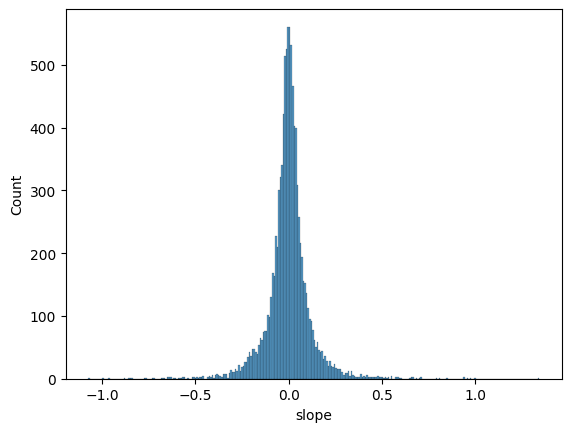

In [ ]:
sns.histplot(e_nominal_df.sample(10000), x='slope')
plt.show()

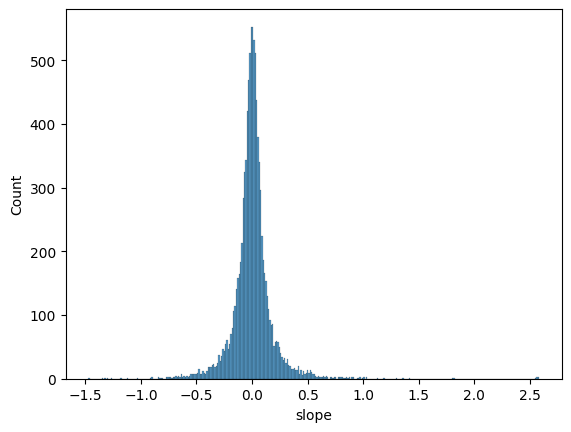

In [ ]:
sns.histplot(pc1_nominal_df.sample(10000), x='slope')
plt.show()

### the PCs themselves
do they explain the variance for multiple genes?

In [3]:
# start in just one tissue
tissue_id = 'Cells_Cultured_fibroblasts' # because only one cell type

pc_output_dir = config['pc_output_dir']
filtered_expression_output_dir = config['filtered_expression_output_dir']

In [6]:
# load in pc data
pc_df = pd.read_csv(f'{prefix}/{pc_output_dir}/{tissue_id}.pcs.bed', sep='\t')
# get a list of all the sample ids
sample_ids = pc_df.columns[4:]
# add a cluster id and pc number column
pc_df['cluster_id'] = pc_df['gene_id'].str.split('_pc').str[0]
pc_df['pc_id'] = pc_df['gene_id'].str.split('_pc').str[1].astype('float')
pc_df['cluster_size'] = pc_df['cluster_id'].str.split('_').apply(len)

pc_df.head()

,#chr,start,end,gene_id,GTEX-111VG,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,...,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5,cluster_id,pc_id,cluster_size
0,chr1,960586,966497,ENSG00000187583.10_ENSG00000187961.13_pc1,-0.012492,-0.032559,-0.081962,-0.080214,-0.018834,-0.061915,...,0.047541,0.004824,0.006920,0.065273,0.091484,-0.029955,-0.014282,ENSG00000187583.10_ENSG00000187961.13,1.0,2
1,chr1,960586,966497,ENSG00000187583.10_ENSG00000187961.13_pc2,0.005204,0.049607,0.041468,0.046362,-0.032715,-0.059307,...,-0.048064,-0.046535,-0.001738,-0.129699,-0.086610,-0.053080,-0.022042,ENSG00000187583.10_ENSG00000187961.13,2.0,2
2,chr1,1659011,1692728,ENSG00000189339.11_ENSG00000248333.8_pc1,-0.023394,-0.007673,-0.032262,0.041808,0.042320,0.009267,...,-0.031412,-0.080867,-0.062225,0.000073,-0.027968,0.049871,0.031654,ENSG00000189339.11_ENSG00000248333.8,1.0,2
3,chr1,1659011,1692728,ENSG00000189339.11_ENSG00000248333.8_pc2,0.004411,0.029045,-0.037281,-0.016904,-0.030414,0.011592,...,-0.036408,0.084067,-0.027125,0.005919,0.037338,0.017079,-0.045869,ENSG00000189339.11_ENSG00000248333.8,2.0,2
4,chr1,1724323,1745992,ENSG00000008128.22_ENSG00000215790.6_pc1,0.005625,-0.028615,-0.058112,-0.015800,0.015038,-0.003349,...,0.055570,0.043555,0.009709,-0.007426,-0.060154,0.031684,-0.034029,ENSG00000008128.22_ENSG00000215790.6,1.0,2


Text(0.5, 1.0, 'Pairwise correlations between all pcs')

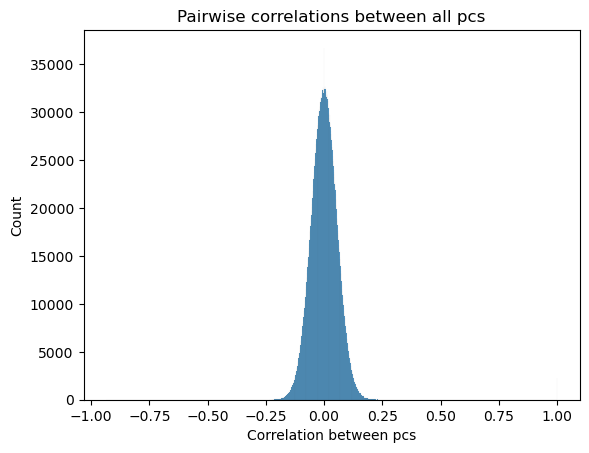

In [17]:
## qc check - are the pcs correlated to each other?
corrs = pc_df[sample_ids].transpose().corr()

sns.histplot(corrs.values.flatten())
plt.xlabel('Correlation between pcs')
plt.title('Pairwise correlations between all pcs')

In [25]:
# load in gene expression data
expression_df = pd.read_csv(f'{prefix}/{filtered_expression_output_dir}/{tissue_id}.v8.normalized_expression.cluster_genes.bed', sep='\t')
# add a cluster id and pc number column
expression_df['cluster_id'] = expression_df['gene_id'].str.split('_e_').str[0]
expression_df['egene_id'] = expression_df['gene_id'].str.split('_e_').str[1]

expression_df.head()

,#chr,start,end,gene_id,GTEX-111VG,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,...,GTEX-ZVP2,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5,cluster_id,egene_id
0,chr1,960586,966497,ENSG00000187583.10_ENSG00000187961.13_e_ENSG00...,-0.013115,-0.055819,-0.090444,-0.091985,0.004575,-0.013917,...,-0.023902,0.066875,0.031793,0.006578,0.130061,0.125158,0.007906,0.001810,ENSG00000187583.10_ENSG00000187961.13,ENSG00000187961.13
1,chr1,960586,966497,ENSG00000187583.10_ENSG00000187961.13_e_ENSG00...,-0.006866,0.003739,-0.040659,-0.036323,-0.034702,-0.085119,...,-0.053182,0.009170,-0.024076,0.004492,-0.025653,0.021175,-0.055821,-0.024654,ENSG00000187583.10_ENSG00000187961.13,ENSG00000187583.10
2,chr1,1659011,1692728,ENSG00000189339.11_ENSG00000248333.8_e_ENSG000...,-0.016525,0.010553,-0.047886,0.024311,0.016909,0.014267,...,0.057456,-0.046688,-0.017291,-0.066444,0.003485,-0.001198,0.050554,-0.000734,ENSG00000189339.11_ENSG00000248333.8,ENSG00000248333.8
3,chr1,1659011,1692728,ENSG00000189339.11_ENSG00000248333.8_e_ENSG000...,-0.021630,-0.023068,-0.004732,0.043878,0.052115,0.000848,...,0.023325,-0.004544,-0.114601,-0.035045,-0.003366,-0.044418,0.030785,0.052362,ENSG00000189339.11_ENSG00000248333.8,ENSG00000189339.11
4,chr1,1724323,1745992,ENSG00000008128.22_ENSG00000215790.6_e_ENSG000...,0.022301,-0.006302,0.052893,0.030058,-0.026409,0.009420,...,-0.001885,-0.067950,-0.025478,-0.011199,0.019256,0.051944,-0.050737,0.053034,ENSG00000008128.22_ENSG00000215790.6,ENSG00000008128.22


In [26]:
# take an example cluster
cluster_id = expression_df['cluster_id'].iloc[22]
cluster_id

'ENSG00000142615.7_ENSG00000162438.11_ENSG00000215704.9'

In [27]:
# the expression and pc values for this cluster
expression_cluster = expression_df[expression_df['cluster_id'] == cluster_id].reset_index()
pc_cluster = pc_df[pc_df['cluster_id'] == cluster_id].reset_index()

for i in range(len(expression_cluster)):
    for j in range(len(pc_cluster)):
        # pull the right data
        pc_values = pc_cluster.loc[j, sample_ids].astype('float')
        expression_values = expression_cluster.loc[i, sample_ids].astype('float')
        # get the r squared value
        slope, intercept, r_value, p_value, std_err = linregress(pc_values, expression_values)
        print('{:.2f}% of {} variance explained by pc{}'.format((r_value**2)*100, 
                                                            expression_cluster.iloc[i]['egene_id'], 
                                                            pc_cluster.iloc[j]['pc_id']))

76.82% of ENSG00000162438.11 variance explained by pc1.0
15.82% of ENSG00000162438.11 variance explained by pc2.0
7.36% of ENSG00000162438.11 variance explained by pc3.0
82.52% of ENSG00000142615.7 variance explained by pc1.0
0.58% of ENSG00000142615.7 variance explained by pc2.0
16.90% of ENSG00000142615.7 variance explained by pc3.0
73.91% of ENSG00000215704.9 variance explained by pc1.0
23.60% of ENSG00000215704.9 variance explained by pc2.0
2.49% of ENSG00000215704.9 variance explained by pc3.0


In [28]:
# for each cluster, for each pc, pull the largest two values

# the expression and pc values for this cluster
for idx, row in tqdm(pc_df.iterrows(), total=pc_df.shape[0]):
    cluster_id
    expression_cluster = expression_df[expression_df['cluster_id'] == row['cluster_id']].reset_index()
    gene_variances = []
    for i in range(len(expression_cluster)):
        # pull the right data
        pc_values = row[sample_ids].astype('float')
        expression_values = expression_cluster.loc[i, sample_ids].astype('float')
        # get the r squared value
        slope, intercept, r_value, p_value, std_err = linregress(pc_values, expression_values)
        gene_variances.append((r_value**2)*100)
    gene_variances.sort()
    pc_df.loc[idx, 'largest_variance'] = gene_variances[-1]
    pc_df.loc[idx, 'second_largest_variance'] = gene_variances[-2]

    

  0%|          | 0/2287 [00:00<?, ?it/s]

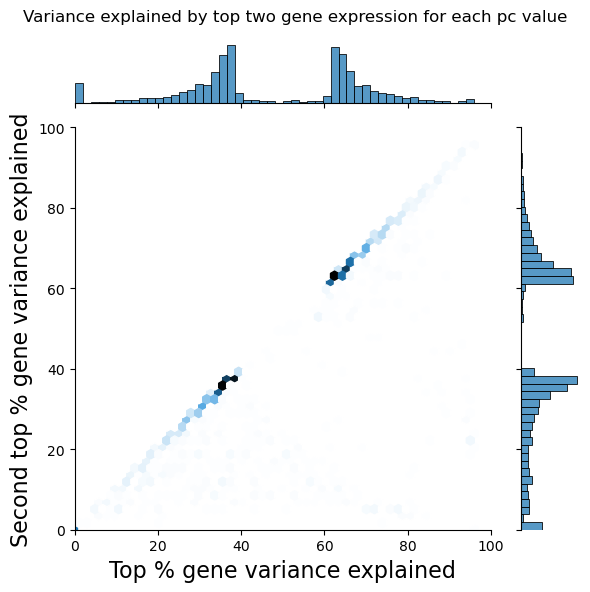

In [29]:
# Create the jointplot
jplot = sns.jointplot(data=pc_df, x='largest_variance', y='second_largest_variance', kind='hex', gridsize=50, marginal_kws=dict(bins=50))

# Set labels
jplot.set_axis_labels('Top % gene variance explained', 'Second top % gene variance explained', fontsize=16)

plt.suptitle('Variance explained by top two gene expression for each pc value')
jplot.fig.tight_layout()
jplot.ax_joint.set_xlim(0,100)
jplot.ax_joint.set_ylim(0,100)
# Show the plot
plt.show()


In [30]:
pc_df['pc_id_clip'] = pc_df['pc_id'].clip(0,4)

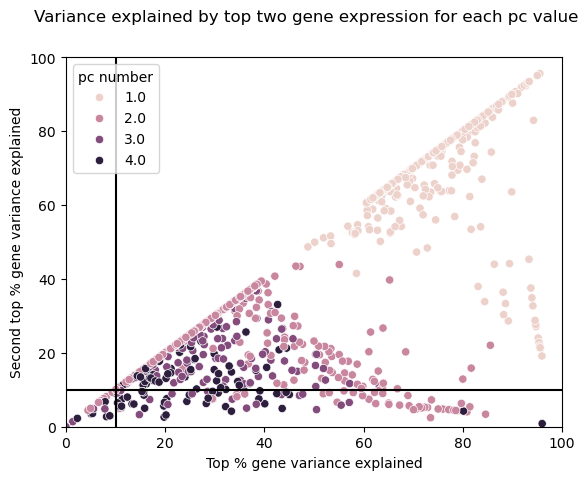

In [31]:
# Create the jointplot, broken up by pc number 
ax = sns.scatterplot(data=pc_df, x='largest_variance', y='second_largest_variance', hue='pc_id_clip')

# Set labels
ax.set_xlabel('Top % gene variance explained')
ax.set_ylabel('Second top % gene variance explained')

plt.suptitle('Variance explained by top two gene expression for each pc value')

ax.set_xlim(0,100)
ax.set_ylim(0,100)
ax.hlines(10, 0, 100, color='k')
ax.vlines(10, 0, 100, color='k')


# Show the plot
plt.legend(title='pc number')
plt.show()


In [36]:
pc_df['10_var_two_genes_filter'] = (pc_df['largest_variance']>10) & (pc_df['second_largest_variance']>10)
pc_df['20_var_two_genes_filter'] = (pc_df['largest_variance']>20) & (pc_df['second_largest_variance']>20)


# write out list of pcs that pass variance filters
pc_df.to_csv(f'{prefix}/{pc_output_dir}/{tissue_id}.pcs.variances.csv', sep='\t')

pull out specific examples and make genome browser type tracks

In [37]:
# load gene annotations
full_gencode=pd.read_csv('/home/klawren/oak/pcqtls/data/references/processed_gencode.v26.GRCh38.genes.gtf', sep='\t', skiprows=range(6), 
            header=None, names=['chr', 'dataset', 'type', 'start','end', '.', 'strand', 'na', 'info'])

full_gencode = full_gencode[full_gencode['type']=='transcript']
full_gencode['transcript_id'] = full_gencode['info'].str.split(';').str[1].str.split('\"').str[-2]

# filter to just the genes in clusters on the chromosome we're considering
gene_ids = expression_df['egene_id'].unique()
gid_gencode = full_gencode.set_index('transcript_id').loc[gene_ids]
gid_gencode = gid_gencode.drop_duplicates()
gid_gencode['tss_start'] = np.where(gid_gencode['strand'] == '+', gid_gencode['start'], gid_gencode['end'])


In [160]:
largest_cluster_id = expression_df['cluster_id'].str.split('_').apply(len).idxmax()

In [161]:
# pull an example cluster
cluster_id = expression_df['cluster_id'].iloc[largest_cluster_id]

expression_cluster = expression_df[expression_df['cluster_id'] == cluster_id].reset_index()
pc_cluster = pc_df[pc_df['cluster_id'] == cluster_id].reset_index()

# pull gene locations 
cluster_gencode = gid_gencode.loc[expression_cluster['egene_id']]

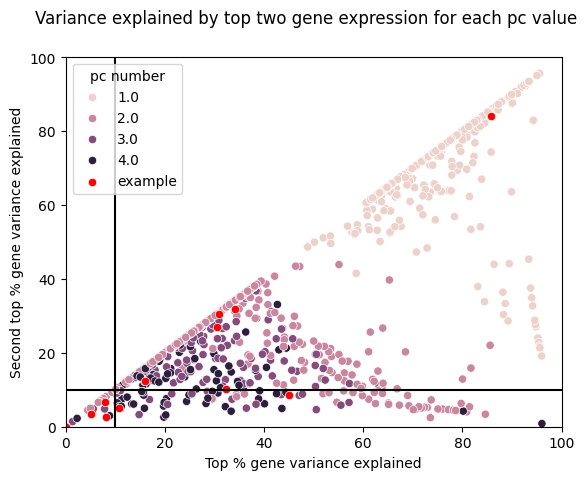

In [162]:
# highlight the point on the scatterplot
# Create the jointplot, broken up by pc number 
ax = sns.scatterplot(data=pc_df, x='largest_variance', y='second_largest_variance', hue='pc_id_clip')

ax = sns.scatterplot(data=pc_df[pc_df['cluster_id'] == cluster_id], 
                     x='largest_variance', y='second_largest_variance', color='r', label='example')




# Set labels
ax.set_xlabel('Top % gene variance explained')
ax.set_ylabel('Second top % gene variance explained')

plt.suptitle('Variance explained by top two gene expression for each pc value')

ax.set_xlim(0,100)
ax.set_ylim(0,100)
ax.hlines(10, 0, 100, color='k')
ax.vlines(10, 0, 100, color='k')


# Show the plot
plt.legend(title='pc number')
plt.show()


In [163]:
# the expression and pc values for this cluster
expression_cluster = expression_df[expression_df['cluster_id'] == cluster_id].reset_index()
pc_cluster = pc_df[pc_df['cluster_id'] == cluster_id].reset_index()

rs = np.zeros((len(expression_cluster), len(pc_cluster)))

for i in range(len(expression_cluster)):
    for j in range(len(pc_cluster)):
        # pull the right data
        pc_values = pc_cluster.loc[j, sample_ids].astype('float')
        expression_values = expression_cluster.loc[i, sample_ids].astype('float')
        # get the r squared value
        slope, intercept, r_value, p_value, std_err = linregress(pc_values, expression_values)
        rs[i,j] = (r_value**2)*100

rs_df = pd.DataFrame(rs, columns=[f'pc{i+1}' for i in range(len(pc_cluster))], index=expression_cluster['egene_id'])
# match rs to same order as gencode
rs_df = rs_df.loc[cluster_gencode.index]
rs_df.reset_index()

# add the location for the variance to be ploted as the gene tss
rs_df['position'] = cluster_gencode['tss_start']

# split out all the pc values into one column
rs_melt_df = rs_df.reset_index().melt(id_vars=['position', 'transcript_id'], value_vars=rs_df.columns[:-1].values, 
                  var_name='pc_num')


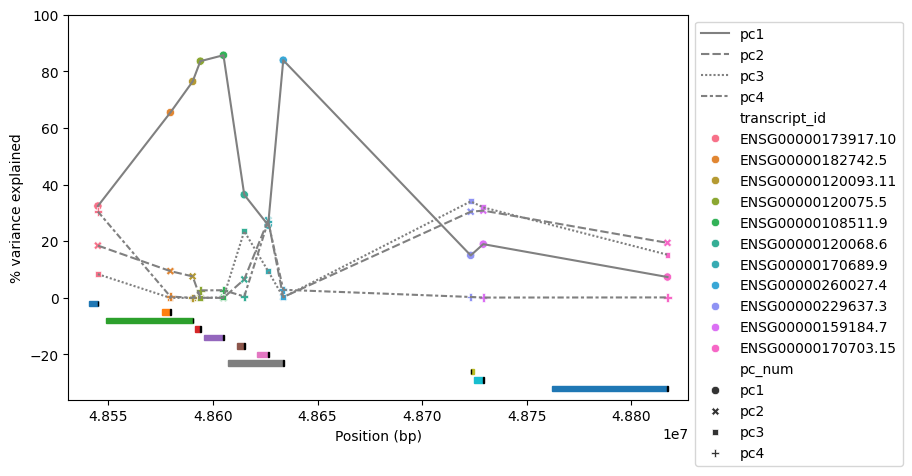

In [191]:
# plot 
add_text=False
max_num_pcs = 4


fig, ax = plt.subplots(figsize=(8,5))
# set axis limits 
ax.set_ylim(-(len(cluster_gencode)+1)*3,100)
x_padding = 10000
ax.set_xlim(cluster_gencode['start'].min() - x_padding, cluster_gencode['end'].max() + x_padding)


# add a rectangle for each gene location
for i in range(len(cluster_gencode)):
    row = cluster_gencode.iloc[i]
    # rectangle patch for gene body
    rect = patches.Rectangle((row['start'], -3-i*3), row['end']-row['start'], 2, linewidth=1, edgecolor=sns.color_palette()[i%10], facecolor=sns.color_palette()[i%10])
    ax.add_patch(rect)
    # black line for tss location
    rect = patches.Rectangle((row['tss_start'], -3-i*3), 200, 2, linewidth=1, edgecolor='k', facecolor='k')
    ax.add_patch(rect)

plot_rs_melt_df = rs_melt_df[rs_melt_df['pc_num'].isin([f'pc{i+1}' for i in range(max_num_pcs)])]

# plot the varaince explained as a scatterplot
sns.lineplot(plot_rs_melt_df, y='value', x='position', style='pc_num', color='grey')
sns.scatterplot(plot_rs_melt_df, y='value', x='position', hue='transcript_id', style='pc_num', ax=ax)

if add_text:
    # add text to the scatterplot
    for i in range(plot_rs_melt_df.shape[0]):
        ax.text(plot_rs_melt_df['position'].iloc[i]+100, plot_rs_melt_df['value'].iloc[i]+1, 
            '{:.2f}%'.format(plot_rs_melt_df['value'].iloc[i]), horizontalalignment='left', size='medium', color='k')

# Add the patch to the Axes
ax.set_xlabel('Position (bp)')
ax.set_ylabel('% variance explained')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()